In [1]:
from os import listdir
from influence import influence_diffusion
import pickle as pkl
import networkx as nx
import numpy as np
from math import ceil
from cost import degree_cost, uniform_cost, betweeness_cost
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
NUM_THREADS = 24
NUM_STEPS = 50
COST_FN = "uniform"
DATASET_NAME = "lastfm_asia"

In [3]:
G = nx.Graph()
with open(f"data/raw/{DATASET_NAME}_edges.csv", "r") as f:
    f.readline()  # Skip header
    for line in f:
        a, b = map(int, line.strip().split(","))
        G.add_edge(a, b)
print(f"Number of nodes: {G.number_of_nodes()}")
G = nx.Graph(nx.subgraph(G, max(list(nx.connected_components(G)), key=len))) # Keep only the largest component
print(f"Number of nodes in largest component: {G.number_of_nodes()}")
print("Number of edges:", G.number_of_edges())

Number of nodes: 7624
Number of nodes in largest component: 7624
Number of edges: 27806


In [4]:
from collections import defaultdict

degrees = defaultdict(int, nx.degree(G)) # Degree of each node
t = np.array([ceil(degrees[v] / 2) for v in range(max(G.nodes()) + 1)]) # Thresholds for each node

In [5]:
if COST_FN == "degree":
    cost_fn = degree_cost(degrees)
    max_k = np.sum(np.array(list(degrees.values())) / 2).item()
elif COST_FN == "uniform":
    cost_fn = uniform_cost()
    max_k = G.number_of_nodes()
elif COST_FN == "betweeness":
    betweenness = nx.betweenness_centrality(G)
    cost_fn = betweeness_cost(betweenness)
    max_k = np.sum(np.array(list(betweenness.values()))).item()
else:
    raise ValueError(f"Unknown cost function: {COST_FN}")

In [6]:
RESULTS_DIR = f"results/{DATASET_NAME}"
results = list(filter(lambda s: COST_FN in s, listdir(RESULTS_DIR)))

In [7]:
influence_sizes = defaultdict(list)
influence_ratios = defaultdict(list)
influence_diffs = defaultdict(list)
ss_sizes = defaultdict(list)

for result in sorted(results, key=lambda s: int(s.split(".")[0].split("_")[2])):
    with open(f"{RESULTS_DIR}/{result}", "rb") as f:
        _, alg_name, ss_size = result.split(".")[0].split("_")
        S, _, desired_k, time = pkl.load(f)
        cost = sum([cost_fn(n, G) for n in S])
        S = set(map(int, S))
        I, sizes, i = influence_diffusion(G, S, t)
        influence_ratio = len(I) / len(S)
        print(alg_name, len(I), cost, influence_ratio)
        influence_diffs[alg_name].append(len(I) - len(S))
        influence_sizes[alg_name].append(len(I))
        influence_ratios[alg_name].append(influence_ratio)
        ss_sizes[alg_name].append(len(S))

purp 29 1 29.0
wtss 4 1 4.0
greedy 14 1 14.0
random 2 2 1.0
wtss 336 154 2.1818181818181817
random 247 155 1.5935483870967742
purp 1002 154 6.5064935064935066
greedy 2500 154 16.233766233766232
greedy 6208 307 20.221498371335503
purp 3320 307 10.814332247557003
wtss 705 307 2.2964169381107493
random 474 308 1.5389610389610389
greedy 6736 460 14.643478260869566
random 748 461 1.6225596529284165
purp 6054 460 13.160869565217391
wtss 1158 460 2.517391304347826
random 954 614 1.5537459283387622
purp 6877 613 11.218597063621534
wtss 2086 613 3.402936378466558
greedy 7099 613 11.580750407830342
wtss 5010 766 6.54046997389034
purp 7121 766 9.296344647519582
random 1228 767 1.6010430247718384
greedy 7211 766 9.413838120104439
purp 7234 919 7.871599564744288
random 1582 920 1.7195652173913043
wtss 5880 919 6.398258977149075
greedy 7330 919 7.976060935799782
wtss 6883 1072 6.420708955223881
greedy 7363 1072 6.8684701492537314
random 1851 1073 1.7250698974836907
purp 7340 1072 6.847014925373134
g

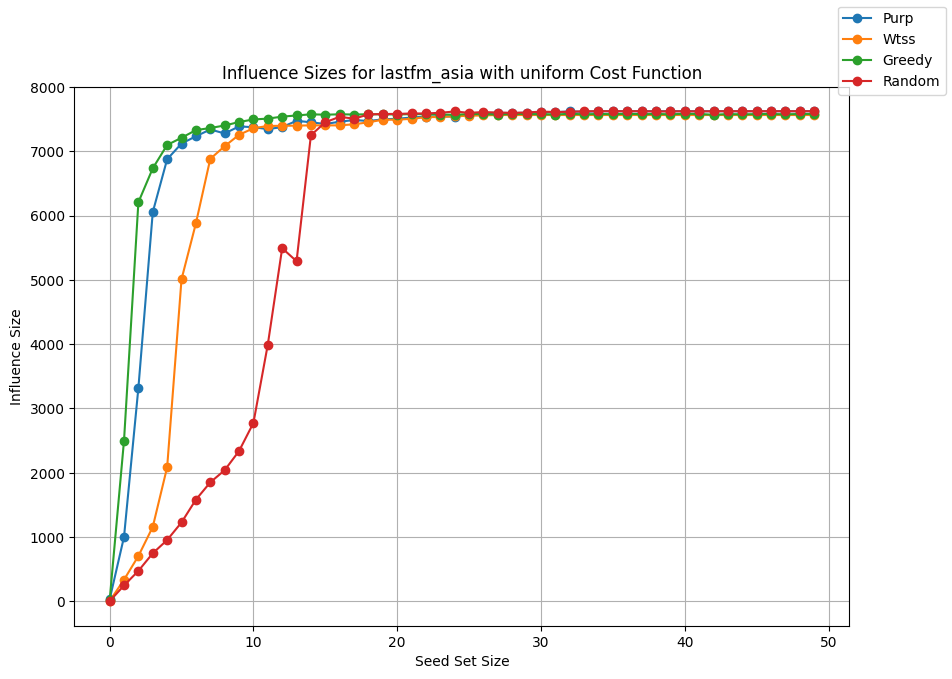

In [8]:
fig, ax = plt.subplots(figsize=(10, 7))
for alg_name, data in influence_sizes.items():
    ax.plot(data, label=alg_name.title(), marker='o', linestyle='-')
fig.legend()
ax.grid()
ax.set_title(f"Influence Sizes for {DATASET_NAME} with {COST_FN} Cost Function")
ax.set_xlabel("Seed Set Size")
ax.set_ylabel("Influence Size")
fig.show()

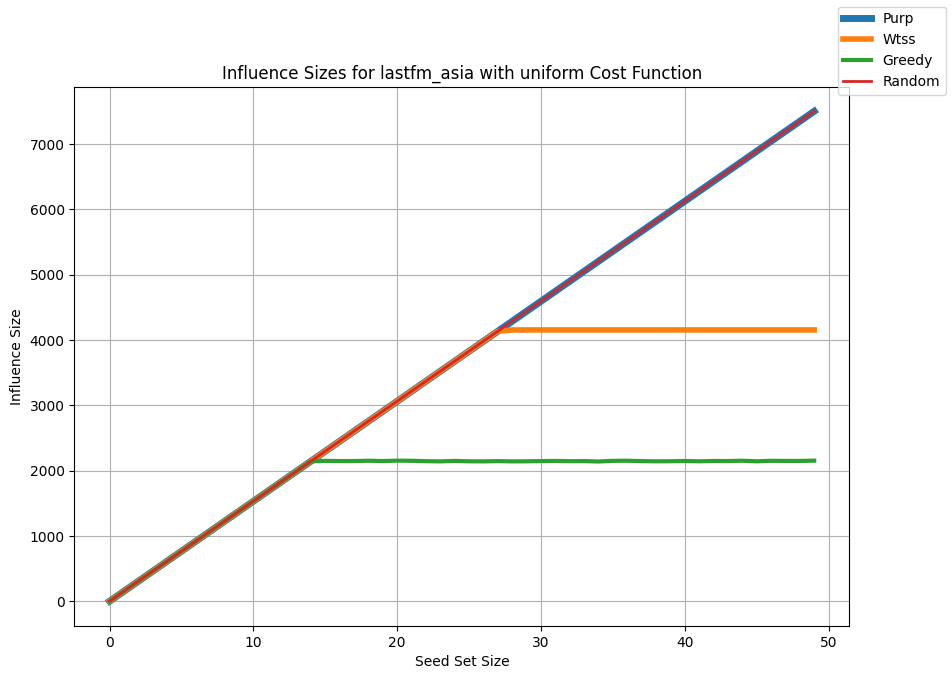

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))
i = 5
for alg_name, data in ss_sizes.items():
    ax.plot(data, label=alg_name.title(), linestyle='-', linewidth=i)
    i -= 1
fig.legend()
ax.grid()
ax.set_title(f"Influence Sizes for {DATASET_NAME} with {COST_FN} Cost Function")
ax.set_xlabel("Seed Set Size")
ax.set_ylabel("Influence Size")
fig.show()

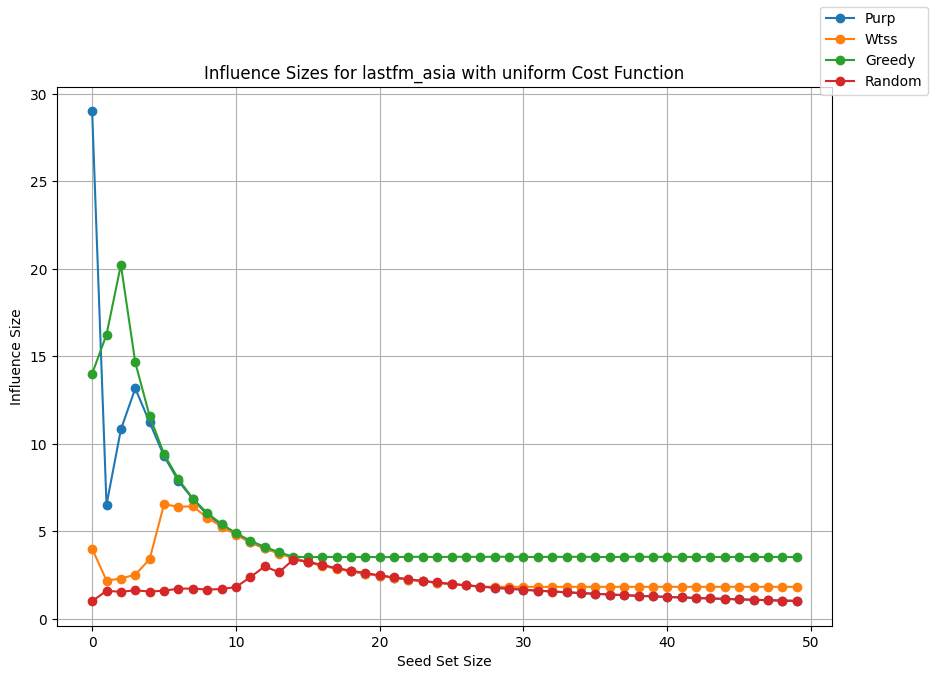

In [10]:
fig, ax = plt.subplots(figsize=(10, 7))
for alg_name, data in influence_ratios.items():
    ax.plot(data, label=alg_name.title(), marker='o', linestyle='-')
fig.legend()
ax.grid()
ax.set_title(f"Influence Sizes for {DATASET_NAME} with {COST_FN} Cost Function")
ax.set_xlabel("Seed Set Size")
ax.set_ylabel("Influence Size")
fig.show()

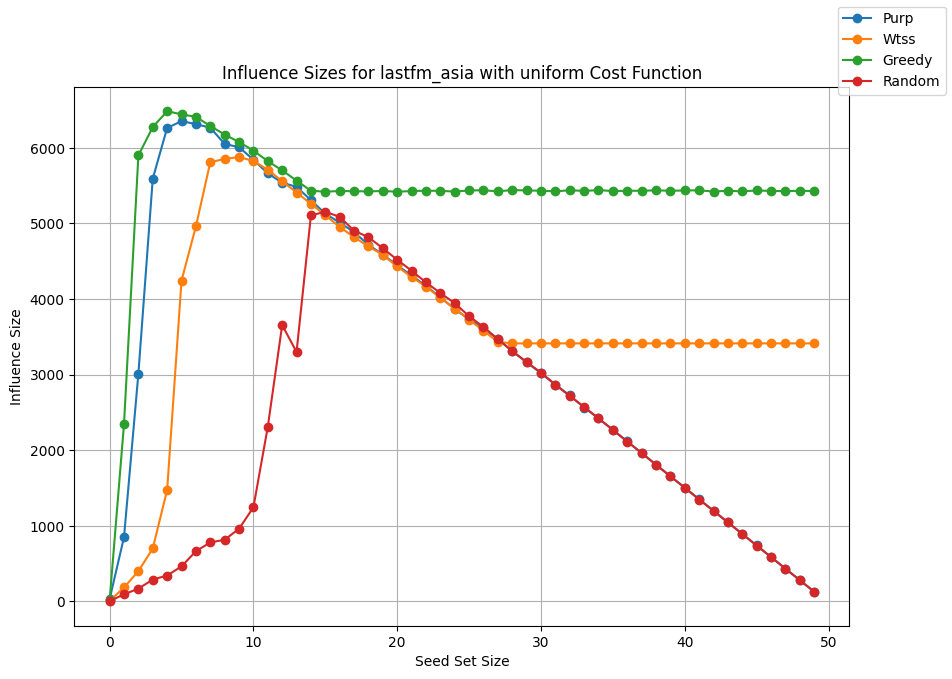

In [11]:
fig, ax = plt.subplots(figsize=(10, 7))
for alg_name, data in influence_diffs.items():
    ax.plot(data, label=alg_name.title(), marker='o', linestyle='-')
fig.legend()
ax.grid()
ax.set_title(f"Influence Sizes for {DATASET_NAME} with {COST_FN} Cost Function")
ax.set_xlabel("Seed Set Size")
ax.set_ylabel("Influence Size")
fig.show()